# Tidal regression

**What does this notebook do?** 

This notebook uses the ([OSU Tidal Prediction Software or OTPS](http://volkov.oce.orst.edu/tides/otps.html)) to tidally tag a time series of Landsat imagery, and then compute pixel-wise regression based on NDWI values.

**Requirements:** 

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

`module load otps`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** August 2018

**Authors:** Robbi Bishop-Taylor, Bex Dunn

## Import modules

In [1]:
import os
import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
from otps import TimePoint
from otps import predict_tide
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEAPlotting
import DEADataHandling

%load_ext autoreload
%autoreload 2

# Create datacube instance
dc = datacube.Datacube(app='Tidal regression')


Failed to resolve driver datacube.plugins.index::s3aio_index


## Import remotely-sensed time series data
Imports a time series of Landsat observations as a DEA `xarray` dataset.

Loading ls5 PQ
    Loading 200 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 67 filtered ls7 timesteps
Loading ls8 PQ
    Loading 83 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


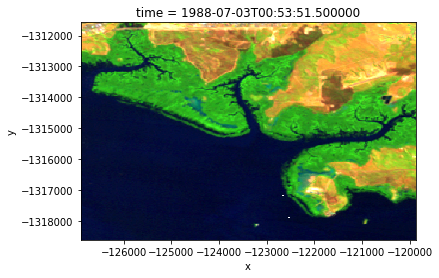

In [131]:
# Set up analysis data query using 
lat, lon, buffer = -12.463, 130.885, 3500
# lat, lon, buffer = -12.2304047393, 132.279180873, 3500 # Mangrovey site north
# lat, lon, buffer = -12.4020354887, 130.833067822, 3500    
# lat, lon, buffer = -16.4128238421, 123.128438417, 2800  # Tallon island
# lat, lon, buffer = -12.34338, 131.01587, 3500  # Gulf site
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),         
         'crs': 'EPSG:3577',
         'time': ('1987-01-01', '2018-06-30')}

# Mask used to identify bad pixels
mask_dict = {'cloud_acca': 'no_cloud', 
             'cloud_fmask': 'no_cloud', 
             'cloud_shadow_acca':'no_cloud_shadow',
             'cloud_shadow_fmask':'no_cloud_shadow',
             'blue_saturated':False,
             'green_saturated':False,
             'red_saturated':False,
             'nir_saturated':False,
             'swir1_saturated':False,
             'swir2_saturated':False,
             'contiguous': True}

# Import data
data = DEADataHandling.load_clearlandsat(dc=dc, query=query, sensors=['ls5', 'ls7', 'ls8'],
                                         bands_of_interest=['swir1', 'nir', 'green'],
                                         mask_dict=mask_dict, masked_prop=0.01, apply_mask=True)

# Plot data
data[['swir1', 'nir', 'green']].isel(time=6).to_array().plot.imshow(robust=True)


## Tidal modelling using OTPS
and extracts a list of timestamps based on the time and date of acquisition for each Landsat observation. These timestamps can then be used as one of the inputs to the [OSU Tidal Prediction Software (OTPS) tidal model](http://volkov.oce.orst.edu/tides/otps.html) to compute tidal heights at the time of acquisition of each Landsat observation.

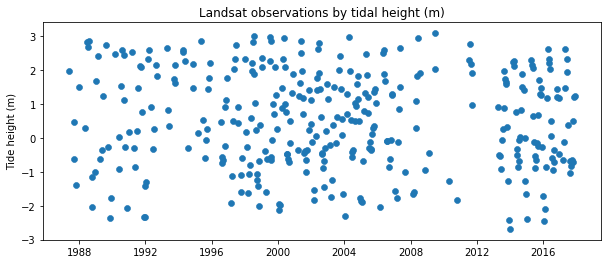

In [132]:
# Extract list of datetimes based on Landsat time of acquisition for each image
observed_datetimes = data.time.data.astype('M8[s]').astype('O').tolist()

#Set a tide post: this is the location the OTPS model uses to compute tides for the supplied datetimes
tidepost_lat, tidepost_lon = -12.48315, 130.85540  # Inside Darwin Harbour
# tidepost_lat, tidepost_lon = -12.1982891466, 132.284149706  # Mangrovey site north
# tidepost_lat, tidepost_lon = -12.3829730224, 130.82327758  # outside Darwin Harbour
# tidepost_lat, tidepost_lon = -16.3970033653, 123.112164727  # Tallon island
# tidepost_lat, tidepost_lon = -12.31286, 130.98268  # Gulf site with change

# The OTPS model requires inputs as 'TimePoint' objects, which are combinations of lon-lat coordinates 
# and a datetime object. You can create a list of these with a list comprehension:
observed_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in observed_datetimes]

# Feed the entire list of timepoints to the OTPS `predict_tide` function:
observed_predictedtides = predict_tide(observed_timepoints)

# For each of the predicted tide objects, extract a list of tidal heights in `m` units relative to mean 
# sea level (the `tide_m` method should not be confused with the `depth_m` method, which gives you the 
# ocean depth at the tide post location that is used by the OTPS model to predict tides)
observed_tideheights = [predictedtide.tide_m for predictedtide in observed_predictedtides]

# Create a dataframe of tidal heights for each Landsat observation
observed_df = pd.DataFrame({'tide_height': observed_tideheights}, 
                           index=pd.DatetimeIndex(observed_datetimes))

# Adds tidal height data back into our original `xarray` dataset so that each Landsat observation is correctly 
# tagged with its corresponding tidal height. Tagged images can then be filtered or composited to study 
# characteristics of the coastline at various tidal stages.
data['tide_heights'] = xr.DataArray(observed_tideheights, [('time', data.time)])

# Plot tidal heights against Landsat observation date
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(observed_df.index, observed_df.tide_height, linewidth=0.6, zorder=1, label='Modelled')
ax.set_title('Landsat observations by tidal height (m)')
ax.set_ylabel('Tide height (m)');


## Compute MNDWI for all timesteps

In [133]:
data['mndwi'] = (data.green - data.swir1) / (data.green + data.swir1)
# data['mndwi'] = (data.green - data.nir) / (data.green + data.nir)
data
# mndwi.plot(col='time', col_wrap=6, robust=True)

<xarray.Dataset>
Dimensions:       (time: 350, x: 281, y: 281)
Coordinates:
  * y             (y) float64 -1.312e+06 -1.312e+06 -1.312e+06 -1.312e+06 ...
  * x             (x) float64 -1.269e+05 -1.269e+05 -1.268e+05 -1.268e+05 ...
  * time          (time) datetime64[ns] 1987-05-30T00:47:23 ...
Data variables:
    swir1         (time, y, x) float64 2.985e+03 3.072e+03 2.75e+03 ...
    nir           (time, y, x) float64 2.429e+03 2.384e+03 2.448e+03 ...
    green         (time, y, x) float64 1.635e+03 1.503e+03 1.186e+03 ...
    data_perc     (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    tide_heights  (time) float64 1.986 0.456 -0.626 -1.399 1.503 0.281 2.836 ...
    mndwi         (time, y, x) float64 -0.2922 -0.343 -0.3974 -0.3869 ...
Attributes:
    crs:      EPSG:3577

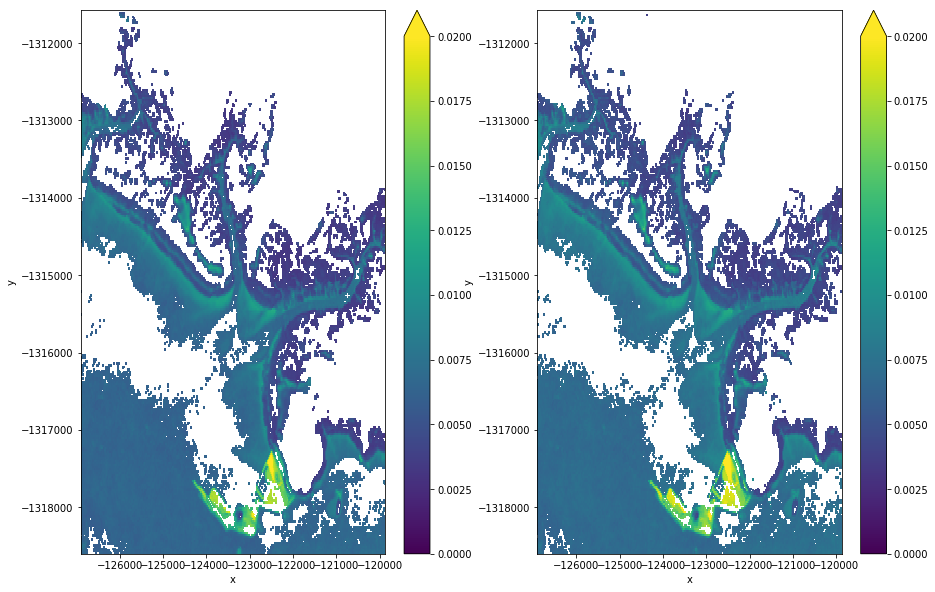

In [140]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt
from  scipy import stats, signal #Required for detrending data and computing regression

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov, cor, slope, intercept, pval, stderr


def lag_linregress_3D2(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n = y.notnull().sum(dim='time')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov, cor, slope, intercept, pval, stderr

cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=data.tide_heights,
                                                        y=data.mndwi, lagx=0)

# fig, axes = plt.subplots(1, 5, figsize=(25, 4))
# cor.plot(robust=True, ax=axes[0])
# axes[0].set_title('Correlation')
# slope.plot(robust=True, ax=axes[1])
# axes[1].set_title('Slope')
# intercept.plot(robust=True, ax=axes[2])
# axes[2].set_title('Intercept')
# pval.plot(robust=True, ax=axes[3])
# axes[3].set_title('P-value')
# stderr.plot(robust=True, ax=axes[4])
# axes[4].set_title('Standard error');

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
stderr.where(pval < 0.05).plot(ax=ax1, vmin=0, vmax=0.02)

cov,cor,slope,intercept,pval,stderr = lag_linregress_3D2(x=data.tide_heights,
                                                        y=data.mndwi, lagx=0)

# fig, axes = plt.subplots(1, 5, figsize=(25, 4))
# cor.plot(robust=True, ax=axes[0])
# axes[0].set_title('Correlation')
# slope.plot(robust=True, ax=axes[1])
# axes[1].set_title('Slope')
# intercept.plot(robust=True, ax=axes[2])
# axes[2].set_title('Intercept')
# pval.plot(robust=True, ax=axes[3])
# axes[3].set_title('P-value')
# stderr.plot(robust=True, ax=axes[4])
# axes[4].set_title('Standard error');

stderr.where(pval < 0.05).plot(ax=ax2, vmin=0, vmax=0.02)

In [117]:
x = data.tide_heights
y = data.mndwi

#3. Compute data length, mean and standard deviation along time axis for further use: 
n     = x.shape[0]
xmean = x.mean(axis=0)
ymean = y.mean(axis=0)
xstd  = x.std(axis=0)
ystd  = y.std(axis=0)
    
#4. Compute covariance along time axis
np.sum((x - xmean)*(y - ymean), axis=0)/(y.notnull().sum(dim='time'))

<xarray.DataArray (y: 521, x: 281)>
array([[ 0.030757,  0.031682,  0.03209 , ..., -0.009537, -0.010544, -0.007064],
       [ 0.032169,  0.028017,  0.030006, ..., -0.010057, -0.013434, -0.007547],
       [ 0.032202,  0.029645,  0.02566 , ..., -0.013044, -0.013516, -0.011895],
       ...,
       [-0.007025, -0.004772, -0.007778, ...,  0.056766,  0.059721,  0.054326],
       [-0.002181, -0.009303, -0.010346, ...,  0.063834,  0.065306,  0.055625],
       [-0.010073, -0.008082, -0.010288, ...,  0.055501,  0.051981,  0.045025]])
Coordinates:
  * y        (y) float64 -1.295e+06 -1.295e+06 -1.296e+06 -1.296e+06 ...
  * x        (x) float64 -1.125e+05 -1.125e+05 -1.125e+05 -1.124e+05 ...

In [116]:
y.notnull().sum(dim='time')

<xarray.DataArray 'mndwi' (y: 521, x: 281)>
array([[401, 400, 399, ..., 365, 364, 364],
       [402, 399, 400, ..., 366, 367, 366],
       [402, 398, 396, ..., 364, 364, 367],
       ...,
       [357, 350, 352, ..., 352, 349, 348],
       [353, 350, 352, ..., 353, 349, 348],
       [351, 349, 351, ..., 352, 351, 349]])
Coordinates:
  * y        (y) float64 -1.295e+06 -1.295e+06 -1.296e+06 -1.296e+06 ...
  * x        (x) float64 -1.125e+05 -1.125e+05 -1.125e+05 -1.124e+05 ...

LinregressResult(slope=0.057815405220463176, intercept=-0.45424011483563204, rvalue=0.3353063189107037, pvalue=4.798652285547915e-12, stderr=0.008112054820018881)


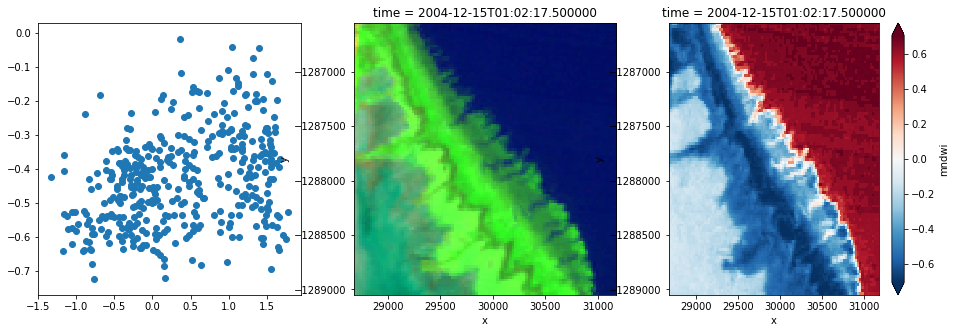

In [38]:
import matplotlib.pyplot as plt
xx, yy, time = 100, 80, 300

figure, axes = plt.subplots(1,3, figsize=(16, 5))
axes[0].scatter(data.isel(x=xx, y=yy).tide_heights, data.isel(x=xx, y=yy).mndwi)
data[['swir1', 'nir', 'green']].isel(x=slice(xx - 50, xx + 50), y=slice(yy - 50, yy + 50), time=time).to_array().plot.imshow(robust=True, ax=axes[1])
data.isel(x=slice(xx - 50, xx + 50), y=slice(yy - 50, yy + 50), time=time).mndwi.plot(robust=True, ax=axes[2])

from scipy.stats import linregress
mask = ~np.isnan(data.isel(x=xx, y=yy).mndwi) & ~np.isnan(data.isel(x=xx, y=yy).tide_heights)
print(linregress(data.isel(x=xx, y=yy).tide_heights[mask], data.isel(x=xx, y=yy).mndwi[mask]))

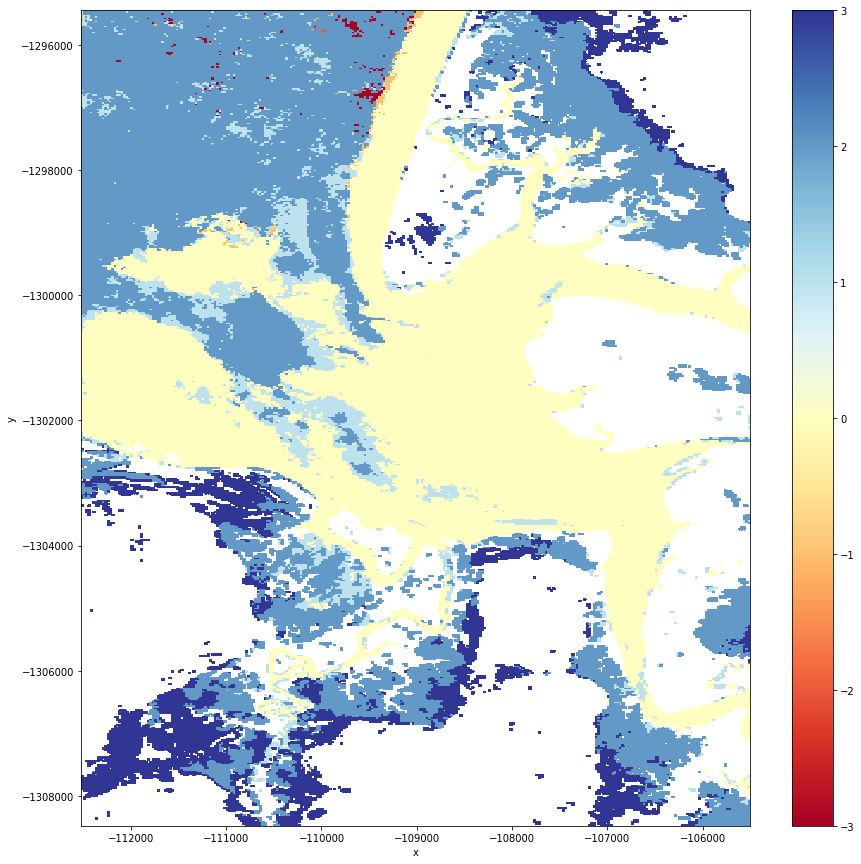

In [109]:
lagged_arrays = []
max_lag = 3
for i in range(-max_lag, max_lag+1):
    
    _, lagged_cor, _, _, lagged_pval, _ = lag_linregress_3D(x=data.tide_heights, y=data.mndwi, lagx=i)
    lagged_arrays.append(lagged_cor.where(lagged_pval < 0.05))
    
lagged_dataarray = xr.concat(lagged_arrays, dim='lag')
lagged_dataarray['lag'] = lagged_dataarray['lag'] - max_lag

plt.figure(figsize=(15, 15))
all_nan = lagged_dataarray.notnull().max(dim=['lag'])
max_index = lagged_dataarray.fillna(0).argmax(dim='lag')
lagged_dataarray['lag'][max_index].where(all_nan).plot(cmap='RdYlBu')

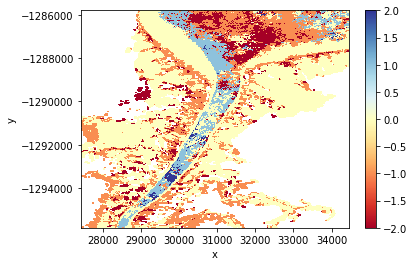

<xarray.DataArray 'mndwi' (tide_height: 469, y: 281, x: 281)>
array([[[ 0.610101,  0.595448, ..., -0.546552, -0.546552],
        [ 0.568323,  0.568323, ..., -0.558449, -0.541613],
        ...,
        [ 0.333333,  0.31307 , ..., -0.562949, -0.583581],
        [ 0.36965 ,  0.36965 , ..., -0.549567, -0.604084]],

       [[ 0.632823,  0.603518, ..., -0.58238 , -0.58238 ],
        [ 0.602634,  0.602634, ..., -0.566438, -0.553194],
        ...,
        [ 0.414966,  0.410921, ..., -0.604307, -0.659653],
        [ 0.443279,  0.43364 , ..., -0.575276, -0.664493]],

       ...,

       [[ 0.700457,  0.686124, ..., -0.529621, -0.529621],
        [ 0.700457,  0.700457, ..., -0.458049, -0.472737],
        ...,
        [ 0.660612,  0.715374, ..., -0.633663, -0.682237],
        [ 0.660612,  0.709832, ..., -0.602447, -0.668206]],

       [[ 0.701375,  0.686921, ..., -0.536212, -0.536212],
        [ 0.701375,  0.701375, ..., -0.461833, -0.483732],
        ...,
        [ 0.688961,  0.718506, ..., -0.64

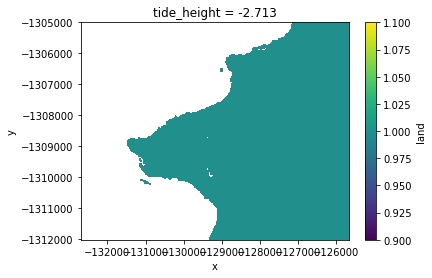

In [167]:
# Change dimension to tide height by renaming time
ds = data.copy(deep=True)[['tide_heights', 'mndwi']]
ds['time'] = ds['tide_heights']
ds.rename({'time': 'tide_height'}, inplace=True)
ds = ds.sortby('tide_height') 

# Take rolling median centred over each observation starting at lowest tide
ds = ds.rolling(tide_height=20, center=True, min_periods=1).median()

# Classify mndwi
ds['land'] = ds['mndwi'] < 0
ds['land'] = ds['land'].where(ds.land == 1)
ds.land.isel(tide_height=0).plot()
ds.mndwi

In [75]:
interval_mult = xr.DataArray(range(1,len(ds.tide_height)+1), [('tide_height', ds.tide_height)])
ds['interval'] = ds.land * interval_mult
ds['test'] = ds.land * ds.tide_heights



ds_combined = ds.isel(tide_height = range(10, len(ds.tide_height)-10, 10)).test.max(dim='tide_height')

from datacube.helpers import write_geotiff
ds_combined = ds_combined.to_dataset(name='test')
ds_combined.attrs['crs'] = data.crs
write_geotiff(filename='test_combined11.tif', dataset=ds_combined[['test']])

In [32]:
ds_combined = ds.isel(tide_height = range(24, len(ds.tide_height)-24, 5)).interval.max(dim='tide_height')

from datacube.helpers import write_geotiff
ds_combined = ds_combined.to_dataset(name='interval')
ds_combined.attrs['crs'] = data.crs
write_geotiff(filename='test_combined11.tif', dataset=ds_combined[['interval']])

In [133]:
test = ds.interval.fillna(0).argmin(dim='tide_height').astype('int32').to_dataset(name='interval')
test
test.attrs['crs'] = data.crs
write_geotiff(filename='test_combined12.tif', dataset=test)

In [137]:
test = ds.test[ds.interval.fillna(0).argmin(dim='tide_height')].to_dataset(name='interval')
test.attrs['crs'] = data.crs
write_geotiff(filename='test_combined13.tif', dataset=test)

In [169]:
# Creating a dataset from scratch:
mndwi = np.random.randint(1, 5, size=(3, 2, 2))
tide_height = np.random.random(3)
lon = [[-99.83, -99.32], [-99.79, -99.23]]
lat = [[42.25, 42.21], [42.63, 42.59]]

# for real use cases, its good practice to supply array attributes such as
# units, but we won't bother here for the sake of brevity
ds = xr.Dataset({'mndwi': (['tide_height', 'x', 'y'],  mndwi)},
                coords={'tide_height': tide_height,
                        'lon': (['x', 'y'], lon),
                        'lat': (['x', 'y'], lat)})

ds.mndwi

<xarray.DataArray 'mndwi' (tide_height: 3, x: 2, y: 2)>
array([[[3, 2],
        [4, 3]],

       [[2, 4],
        [1, 2]],

       [[4, 3],
        [2, 2]]])
Coordinates:
  * tide_height  (tide_height) float64 0.6272 0.2784 0.2952
    lon          (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat          (x, y) float64 42.25 42.21 42.63 42.59
Dimensions without coordinates: x, y

In [165]:
min_inds = ds.mndwi.argmin(dim='tide_height')
ds.mndwi[min_inds]

<xarray.DataArray 'mndwi' (x: 2, y: 2)>
array([[3, 1],
       [2, 3]])
Coordinates:
    tide_height  (x, y) float64 0.5879 0.7382 0.7382 0.5879
    lon          (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat          (x, y) float64 42.25 42.21 42.63 42.59
Dimensions without coordinates: x, y

In [170]:

mndwi = np.random.randint(1, 5, size=(3, 2, 2))
tide_height = np.random.random(3)
lon = [[-99.83, -99.32], [-99.79, -99.23]]
lat = [[42.25, 42.21], [42.63, 42.59]]
xr.DataArray(mndwi, coords=[tide_height, lat, lon], dims=['time','lat','lon']) 

MissingDimensionsError: cannot set variable 'lat' with 2-dimensional data without explicit dimension names. Pass a tuple of (dims, data) instead.

In [115]:
# stacked = ds.interval.stack(z=('x', 'y'))


# def get_last_valid(in_ds):
# #     print(in_ds.values)
# #     test = np.nonzero(np.isnan(in_ds.values))[0][0] -1
# #     print(test)
# #     return in_ds.values[test]
#     return xr.DataArray(1)

# stacked.groupby('z').apply(get_last_valid)

# # get_last_valid(test_ds)

ValueError: 'time' not found in array dimensions ('tide_height', 'y', 'x')

In [ ]:
vals = data.mndwi.values
years = data.tide_heights.values

# Reshape to an array with as many rows as years and as many columns as there are pixels
vals2 = vals.reshape(len(years), -1)
vals2 

# Do a first-degree polyfit
regressions = np.polyfit(years, vals2, 1)

# # Get the coefficients back
trends = regressions[0,:].reshape(vals.shape[1], vals.shape[2])
# plt.imshow(trends)

In [ ]:
vals2.shape

In [ ]:
def linear_reg(x):
    
    mask = ~np.isnan(data.isel(x=xx, y=yy).mndwi) & ~np.isnan(data.isel(x=xx, y=yy).tide_heights)
    print(linregress(data.isel(x=xx, y=yy).mndwi[mask], data.isel(x=xx, y=yy).tide_heights[mask]))
    

In [ ]:
import matplotlib.pyplot as plt
xx, yy, time = 155, 165, 37

figure, axes = plt.subplots(1,3, figsize=(16, 5))
axes[0].scatter(data.isel(x=xx, y=yy).mndwi, data.isel(x=xx, y=yy).tide_heights)
data[['swir1', 'nir', 'green']].isel(x=slice(xx - 50, xx + 50), y=slice(yy - 50, yy + 50), time=time).to_array().plot.imshow(robust=True, ax=axes[1])
data.isel(x=slice(xx - 50, xx + 50), y=slice(yy - 50, yy + 50), time=time).mndwi.plot(robust=True, ax=axes[2])

from scipy.stats import linregress
mask = ~np.isnan(data.isel(x=xx, y=yy).mndwi) & ~np.isnan(data.isel(x=xx, y=yy).tide_heights)
print(linregress(data.isel(x=xx, y=yy).mndwi[mask], data.isel(x=xx, y=yy).tide_heights[mask]))


In [ ]:
data[['swir1', 'nir', 'green']].isel(x=slice(xx - 20, xx + 20), y=slice(yy - 20, yy + 20), time=28).to_array().plot.imshow(robust=True)

In [ ]:
linregress(data.isel(x=xx, y=yy).mndwi[mask], 
                   data.isel(x=xx, y=yy).tide_heights[mask])

In [ ]:
out_array_slope = np.zeros(shape=(281, 281))
out_array_intercept = np.zeros(shape=(281, 281))
out_array_rvalue = np.zeros(shape=(281, 281))
out_array_pvalue = np.zeros(shape=(281, 281))
out_array_stderr = np.zeros(shape=(281, 281))

for xx in range(281):
    
    for yy in range(281):
        
        mask = ~np.isnan(data.isel(x=xx, y=yy).mndwi) & ~np.isnan(data.isel(x=xx, y=yy).tide_heights)

        slope, intercept, rvalue, pvalue, stderr = linregress(data.isel(x=xx, y=yy).mndwi[mask], 
                                                              data.isel(x=xx, y=yy).tide_heights[mask])
        
        out_array_slope[yy, xx] = slope
        out_array_intercept[yy, xx] = intercept
        out_array_rvalue[yy, xx] = rvalue
        out_array_pvalue[yy, xx] = pvalue
        out_array_stderr[yy, xx] = stderr
 

In [ ]:
vmin, vmax = np.percentile(out_array_stderr, [2, 98])

# plt.figure(figsize=(8,8))
# plt.imshow(out_array_stderr, vmin=vmin, vmax=vmax)

In [ ]:
data.mndwi.values[0:4, 0:3, 0:3]

In [ ]:
x_array = 

In [ ]:
vals = data.mndwi.values
years = data.tide_heights.values

# Reshape to an array with as many rows as years and as many columns as there are pixels
vals2 = vals.reshape(len(years), -1)
vals2 

In [ ]:
data.tide_heights.values.shape

In [ ]:
np.array([[1, 3, 1, 2, 5, 6, 1, np.nan, 5, 1],
         [3, 7, 5, 1, 2, 5, 0, 1, 0, 0],
         [2, 2, np.nan, 1, 2, 5, 3, 1, 3, 1]]).shape()

In [ ]:
# Independent variable: one value for each of four timesteps 
x_array = np.array([0.5, 0.2, 0.4, 0.4])

# Dependent variable: four timesteps of 3x3 arrays
y_array = np.array([[[-0.2,   -0.2,   -0.3],
                     [-0.3,   -0.2,   -0.3],
                     [-0.3,   -0.4,   -0.4]],

                    [[-0.2,   -0.2,   -0.4],
                     [-0.3,   np.nan, -0.3],
                     [-0.3,   -0.3,   -0.4]],

                    [[np.nan, np.nan, -0.3],
                     [-0.2,   -0.3,   -0.7],
                     [-0.3,   -0.3,   -0.3]],

                    [[-0.1,   -0.3,   np.nan],
                     [-0.2,   -0.3,   np.nan],
                     [-0.1,   np.nan, np.nan]]])

# Dependent variable
y_array = np.array([[[-0.2,   -0.2,   -0.3],
                     [-0.3,   -0.2,   -0.3],
                     [-0.3,   -0.4,   -0.4]],

                    [[-0.2,   -0.2,   -0.4],
                     [-0.3,   -0.2,   -0.3],
                     [-0.3,   -0.3,   -0.4]],

                    [[-0.2,   -0.2,   -0.3],
                     [-0.2,   -0.3,   -0.7],
                     [-0.3,   -0.3,   -0.3]],

                    [[-0.1,   -0.3,   -0.2],
                     [-0.2,   -0.3,   -0.2],
                     [-0.1,   -0.2,   -0.2]]])



In [ ]:
# Reshape to an array with as many rows as timesteps and as many columns as there are pixels
y_array2 = y_array.reshape(len(y_array), -1)

In [ ]:
# Do a first-degree polyfit
regressions = np.polyfit(x_array, y_array2, 1)
regressions
# # Get the coefficients back
# trends = regressions[0,:].reshape(y_array.shape[1], y_array.shape[2])
# trends

In [ ]:
linregress(np.resize(test, (4, 9)), 
           y_array2)

In [ ]:
np.resize(test, (4, 9))

In [ ]:
y_array2

In [ ]:
x_array.shape

In [ ]:
test = x_array.reshape(len(x_array), -1)

In [ ]:
test.shape 

In [ ]:
np.resize(test, (4, 9))

In [ ]:
import skimage.filters
from scipy import ndimage as nd

test = np.array([[0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
                 [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                 [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                 [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                 [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                 [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                 [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
                 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
                 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
                 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
                 [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                 [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                 [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
                 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
                 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
                 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
                 [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
                 [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
                 [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]])

#struct1 = nd.generate_binary_structure(2, 1)
# test = nd.morphology.binary_dilation(test, iterations=1) #, structure=struct1)

distances = nd.distance_transform_edt(input=test, return_distances=True)

# distances[test == 0] = np.nan

laplace = skimage.filters.laplace(distances, ksize=5, mask=test == 1)

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(12, 8))
ax1.imshow(test)
ax2.imshow(distances)
ax3.imshow(laplace)

# plt.imshow(test)
# plt.imshow()
# distances



In [ ]:
test2

In [ ]:
test2 = nd.convolve(distances, np.array([[0.25, 0.5, 0.25],
                                            [0.5, -3, 0.5],
                                            [0.25, 0.5, 0.25]]), mode='constant', cval=np.nan)

plt.imshow(np.where(test == 1, test2, np.nan) < -0.6)

In [ ]:
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                  [2, 0], [2, 1], [2, 2]])
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)

import matplotlib.pyplot as plt
voronoi_plot_2d(vor)
plt.show()


In [ ]:
struct1 = nd.generate_binary_structure(2, 2)
edges = nd.morphology.binary_dilation(test, iterations=1, structure=struct1) - test
plt.imshow(edges)

y, x = np.nonzero(edges)
points = np.array(list(zip(x, -y)))
vor = Voronoi(points, qhull_options='Qbb Qc Qx')
import matplotlib.pyplot as plt
voronoi_plot_2d(vor)
plt.show()

### To do
1. Extract edge points
2. Compute Voronoi
3. Extract Voronoi polygons
4. Convert to lines? 
3. Drop lines if any point is outside water
4. Drop lines if any end is not connected (not duplicated?)

In [ ]:
vor.point_region

In [ ]:
vor.ridge_vertices

In [6]:
>>> # Import modules
>>> import datacube
>>> import sys

>>> # Import dea-notebooks functions using relative link to Scripts directory
>>> sys.path.append('../10_Scripts')
>>> import DEADataHandling

>>> # Connect to a datacube containing Sentinel data
>>> dc = datacube.Datacube(app='load_clearlandsat')

>>> # Set up spatial and temporal query; note that 'output_crs' and 'resolution' need to be set
>>> query = {'x': (954163, 972163),
...          'y': (-3573891, -3555891),
...          'time': ('2011-06-01', '2013-06-01'),
...          'crs': 'EPSG:3577'}   

>>> # Load observations with less than 25% cloud from ls5, ls7 and ls8 as a single combined dataset
>>> landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, sensors=['ls5', 'ls7', 'ls8'], 
...                                    bands_of_interest=['red', 'green', 'blue'], 
...                                    masked_prop=0.75, apply_mask=True, ls7_slc_off=True)
Loading ls5 PQ
    Loading 4 filtered ls5 timesteps
Loading ls7 PQ
    Loading 29 filtered ls7 timesteps
Loading ls8 PQ
    Loading 3 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data

>>> # Test that function returned data
>>> len(landsat_ds.time) > 0
True

Loading ls5 PQ
    Loading 4 filtered ls5 timesteps
Loading ls7 PQ
    Loading 29 filtered ls7 timesteps
Loading ls8 PQ
    Loading 3 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


True

In [ ]:
# Import modules
import datacube
import sys

# Import dea-notebooks functions using relative link to Scripts directory
sys.path.append('../10_Scripts')
import DEADataHandling

# Connect to a datacube containing Sentinel data
dc = datacube.Datacube(app='load_clearlandsat')

# Set up spatial and temporal query; note that 'output_crs' and 'resolution' need to be set
query = {'x': (954163, 972163),
         'y': (-3573891, -3555891),
         'time': ('2011-06-01', '2013-06-01'),
         'crs': 'EPSG:3577'}   

# Load observations with less than 25% cloud from ls5, ls7 and ls8 as a single combined dataset
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, sensors=['ls5', 'ls7', 'ls8'], 
                                   bands_of_interest=['red', 'green', 'blue'], 
                                   masked_prop=0.75, apply_mask=True, ls7_slc_off=True)

# Test that function returned data
len(landsat_ds.time) > 0